# Approfondissons plus en détail l'exploration du dataset: 

#### recherche d'éléments caractéristiques d'une série

Nous continuons notre exploration du dataset avec l'affinage du nettoyage des données et les premières analyses: 
tout d'abord, nous cherchons à déterminer des façons de reconnaitre une série: Nous cherchons ce qui différencie les séries les unes des autres.
Pour cela, nous nous intéressons à plusieurs paramètres, ou features:
- nombre de mots différents (taille du vocabulaire d'une série)
- nombre moyen de mots dans un épisode
- longueur moyenne des répliques
- termes ayant le score tf-idf le plus élevé: mots caractéristiques d'une série
- entités nommées éventuellement (cela peut rejoindre l'idée précédente de tf-idf)
- bonus (est-ce faisable?) mesurer le registre de langage d'une série

In [1]:
import codecs
import glob
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
import seaborn as sns
#using https://github.com/amueller/word_cloud
from wordcloud import WordCloud

plt.style.use('seaborn-white')
%matplotlib inline

#dataset path
path = "dataset"

Voici une liste de quelques séries célèbres: Nous nous servirons de ces séries comme base d'analyse. Cela présente comme intérêt le fait de pouvoir comparer/vérifier nos résultats avec nos connaissances de ces séries, que nous avont vu pour certaines (que le lecteur se rassure, nous n'avons pas regardé the Vampire Diaries).

In [2]:
series = ["2567_House", "2956_Criminal_Minds", "1262_Lost", "175_The_Walking_Dead", "76_Breaking_Bad", "196_Smallville",
"217_Game_of_Thrones", "1906_The_Vampire_Diaries", "3280_Peaky_Blinders", "1704_Rick_and_Morty", "1039_Narcos",
              "1845_Sherlock_(2010)", "1701_Outlander", "3314_Shameless", "818_Gomorra_(2014)", "413_Dexter",
              "2123_Sense8", "121_Suits", "2469_The_Simpsons", "1718_South_Park", "3259_Stargate_SG-1"]

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = []

for serie in series:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.tokens")
    text = ""
    for episode in listepisodes:
        with codecs.open(episode, "r", "utf-8") as file:
            text += " " + file.read()
    corpus.append(text)

In [88]:
#thanks to codeforfrankfurt, https://github.com/codeforfrankfurt/PolBotCheck/blob/master/polbotcheck/word_cluster.py

vectorizer = TfidfVectorizer(lowercase=True, binary=False, analyzer='word', use_idf = True, stop_words='english')

X = vectorizer.fit_transform(corpus)

#print dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

words_n=30
terms = vectorizer.get_feature_names()

word_cloud_per_serie = {}

for serie in range(len(corpus)):
    feature_index = X[serie, :].nonzero()[1]
    tfidf_scores = zip(feature_index, [X[serie, x] for x in feature_index])
    doc_terms = []
    for word, score in [(terms[i], score) for (i, score) in tfidf_scores]:
        doc_terms.append((word, score))
    important_terms = [(word, score) for word, score in sorted(doc_terms, key=lambda x: x[1], reverse=True)][:words_n]
    word_cloud_per_serie[series[serie]] = important_terms

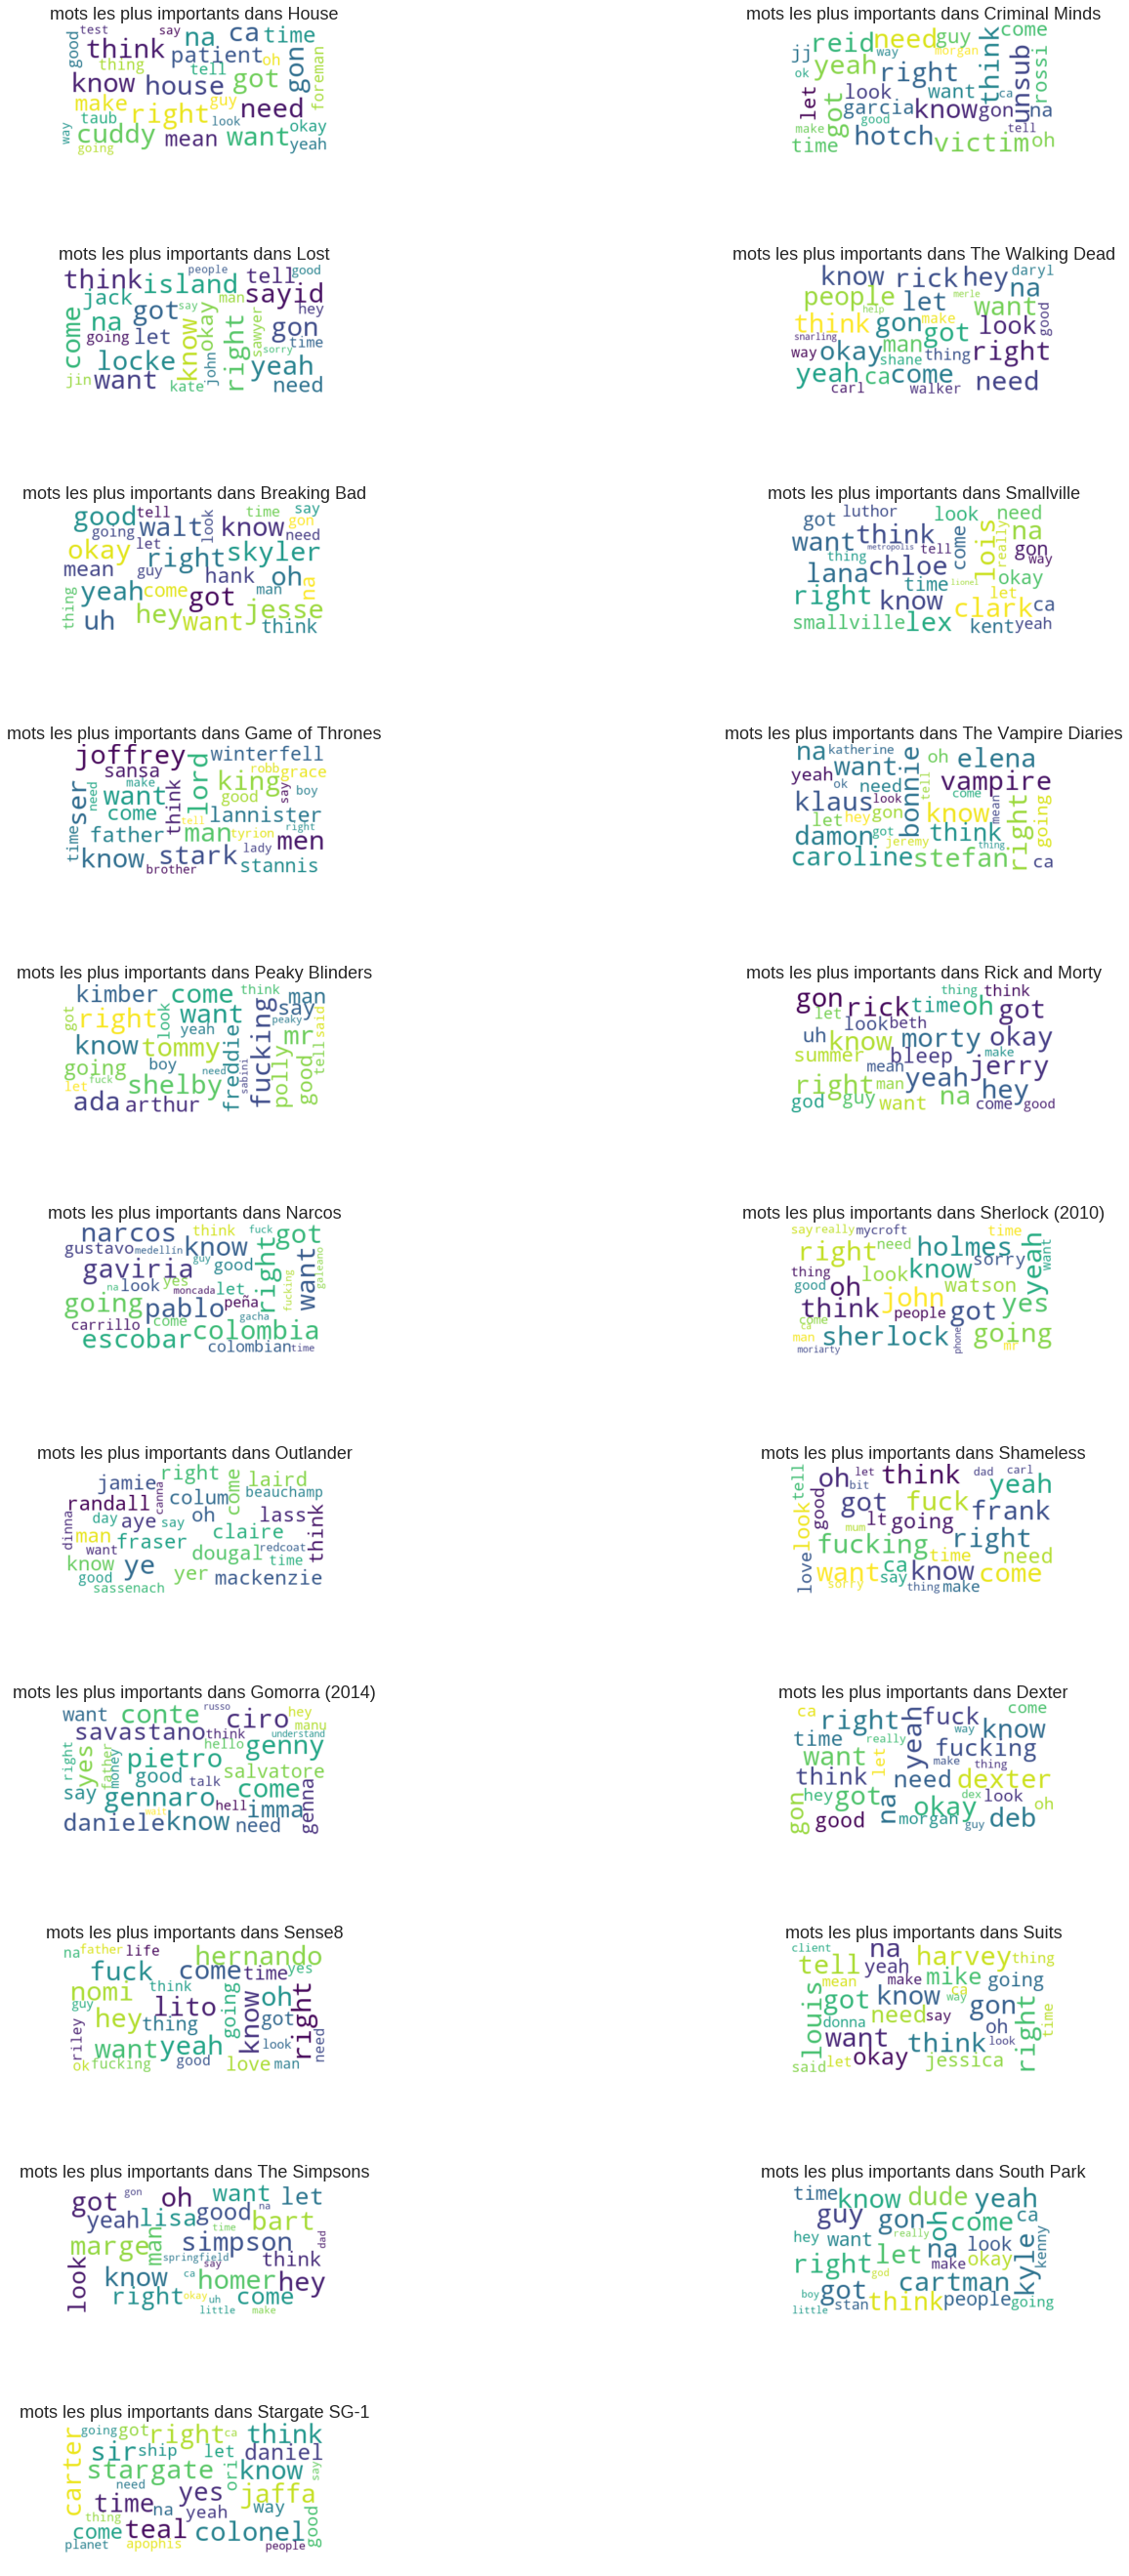

In [89]:
plt.figure(figsize=(30,45))
index = 1
for serie, value in word_cloud_per_serie.items():
    text = " ".join([word for word, tf_idf in value])
    nomserie = " ".join(serie.split("_")[1:])
    wordcloud = WordCloud(background_color="white", max_font_size=40).generate(text)
    plt.subplot(11, 2, index)
    plt.title("mots les plus importants dans "+nomserie, fontsize=18)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    index += 1
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.8, wspace=0.05)
plt.show()

#### Résultat:

De nombreux mots de la langue courante ressortent. On peut noter par exemple la présence de "good", "got", "yeah", "come", "think", "tell", "going" dans plusieurs séries. Cela n'est pas gênant car mot de la langue courante ne veut pas forcément dire "stopword" au sens mot d'apportant pas d'information. Le mot "yeah" par exemple peut être assez révélateur de l'époque à laquelle se déroule la série et du registre de langue des personnages.

On observe que les noms des personnages principaux ressortent immédiatement: "JJ", "Garcia", "Reid", "Hotch" pour Esprits criminels, "Pablo", "Gaviria", "Gustavo", "Carrillo", "Escobar" dans Narcos, etc...

On observe également que certains éléments de langage "familier" resortent: "fucking" dans Narcos, Peaky Blinders, Shameless, Dexter (qui  emploient un langage chatié) par exemple, "fuck" également.

#### Observons maintenant quelques différences de forme des séries:

- voici d'abord la longueur moyenne des lignes des séries:

In [52]:
corpus = []

for serie in series:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.lines")
    text = ""
    for episode in listepisodes:
        with codecs.open(episode, "r", "utf-8") as file:
            text += " " + file.read()
    corpus.append(text)

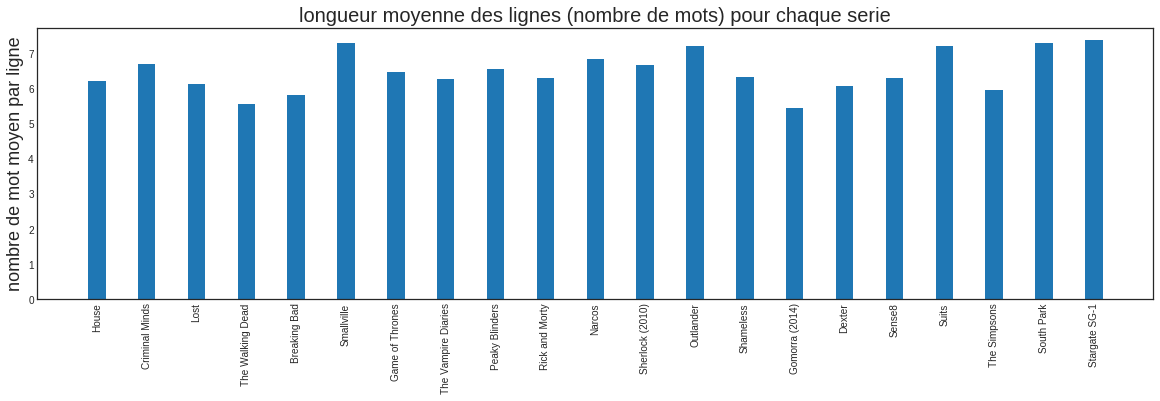

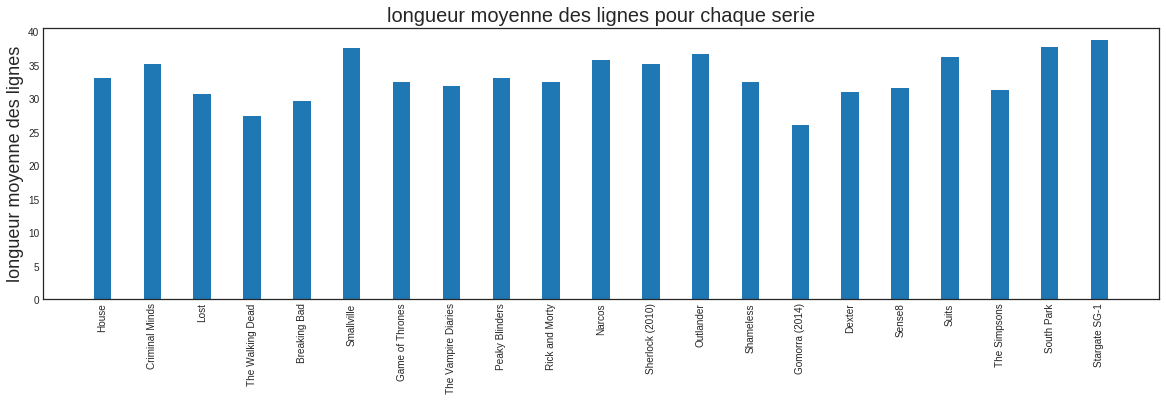

In [67]:
longueurs = []
for i in range(len(series)):
    longueurs.append(np.mean(np.array([len(x.split(" ")) for x in corpus[i].split('\n')])))
    
plt.figure(figsize=(20,5))
plt.ylabel("nombre de mot moyen par ligne", fontsize=18)
plt.title("longueur moyenne des lignes (nombre de mots) pour chaque serie", fontsize=20)
plt.bar(range(len(corpus)), longueurs, width=0.35)
plt.xticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
plt.show()

longueurs = []
for i in range(len(series)):
    longueurs.append(np.mean(np.array([len(x) for x in corpus[i].split('\n')])))
    
plt.figure(figsize=(20,5))
plt.ylabel("longueur moyenne des lignes", fontsize=18)
plt.title("longueur moyenne des lignes pour chaque serie", fontsize=20)
plt.bar(range(len(corpus)), longueurs, width=0.35)
plt.xticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
plt.show()

#### Résultat:

On constate que certaines séries ont des répliques plus "longues" en moyenne: dans stargate SG-1, les répliques sont longues en moyenne (autant en nombre de mots qu'en longueur de ligne) tandis que dans the walking dead ou Gomorra, les répliques sont moins longues.

#### regardons le nombre moyen de mots uniques:
il pourrait s'agir d'un bon indicateur de "richesse" du langage de la série et/ou du nombre de termes abordés.

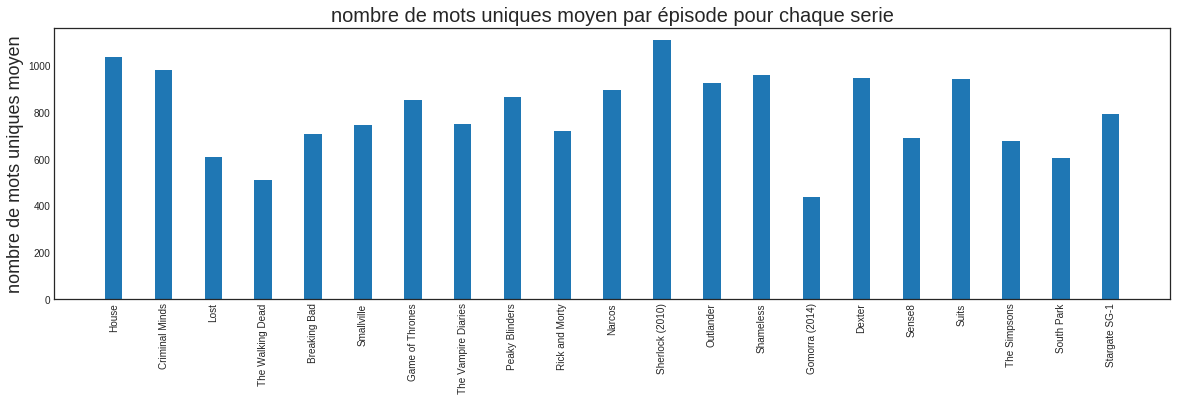

In [74]:
from collections import Counter

nbmots = []
for serie in series:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.tokens")
    lol = 0
    for episode in listepisodes:
        with codecs.open(episode, "r", "utf-8") as file:
            text = file.read()
            lol +=len(Counter(text.split(" ")))
    
    nbmots.append(lol / len(listepisodes))  
    
plt.figure(figsize=(20,5))
plt.ylabel("nombre de mots uniques moyen", fontsize=18)
plt.title("nombre de mots uniques moyen par épisode pour chaque serie", fontsize=20)
plt.bar(range(len(corpus)), nbmots, width=0.35)
plt.xticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
plt.show() 

#### Résultat: 

Mention spéciale à Sherlock qui emploie en moyenne plus de 1000 mots uniques par épisode. Dr House, esprits criminels, shameless ne sont pas loin aussi. On remarque que le nombre de mots uniques par épisode varie du simple au double entre certaines séries. On peut donc penser que cela constituerait un feature intéressant pour caractériser une série et donc un épisode.


### Expérimentation: extraction d'entités nommées

Nous souhaitons mettre en place une méthode d'extraction d'entités nommées pour une série donnée. Les entités nommées sont des objets textuels (par nécessairement des mots simples) catégorisables dans des catégories comme les nom propres, noms d'entreprise, de lieu, etc. Extraire les entités nommées d'une série peut être très utile: Elle peut servir à identifier un coup sûr un épisode d'une série. On peut donc vouloir extraitre les entités nommées pour leur donner un poids important dans une méthode de classification.
On peut au contraire vouloir les extraire pour les enlever...

#### Voici donc plusieurs expérimentations sur l'extraction d'entités nommées

- extraction simple à l'aide du tf-idf et de POS tagging: premiers essais. L'idée est de sélectionner les mots qui ont le plus grand tf-idf, et qui sont également des noms propres ou des mots n'appartement pas à la langue anglaise (nous utiliserons pour cela le lexicon de nltk). Il s'agit d'une technique rudimentaire à but expérimental.

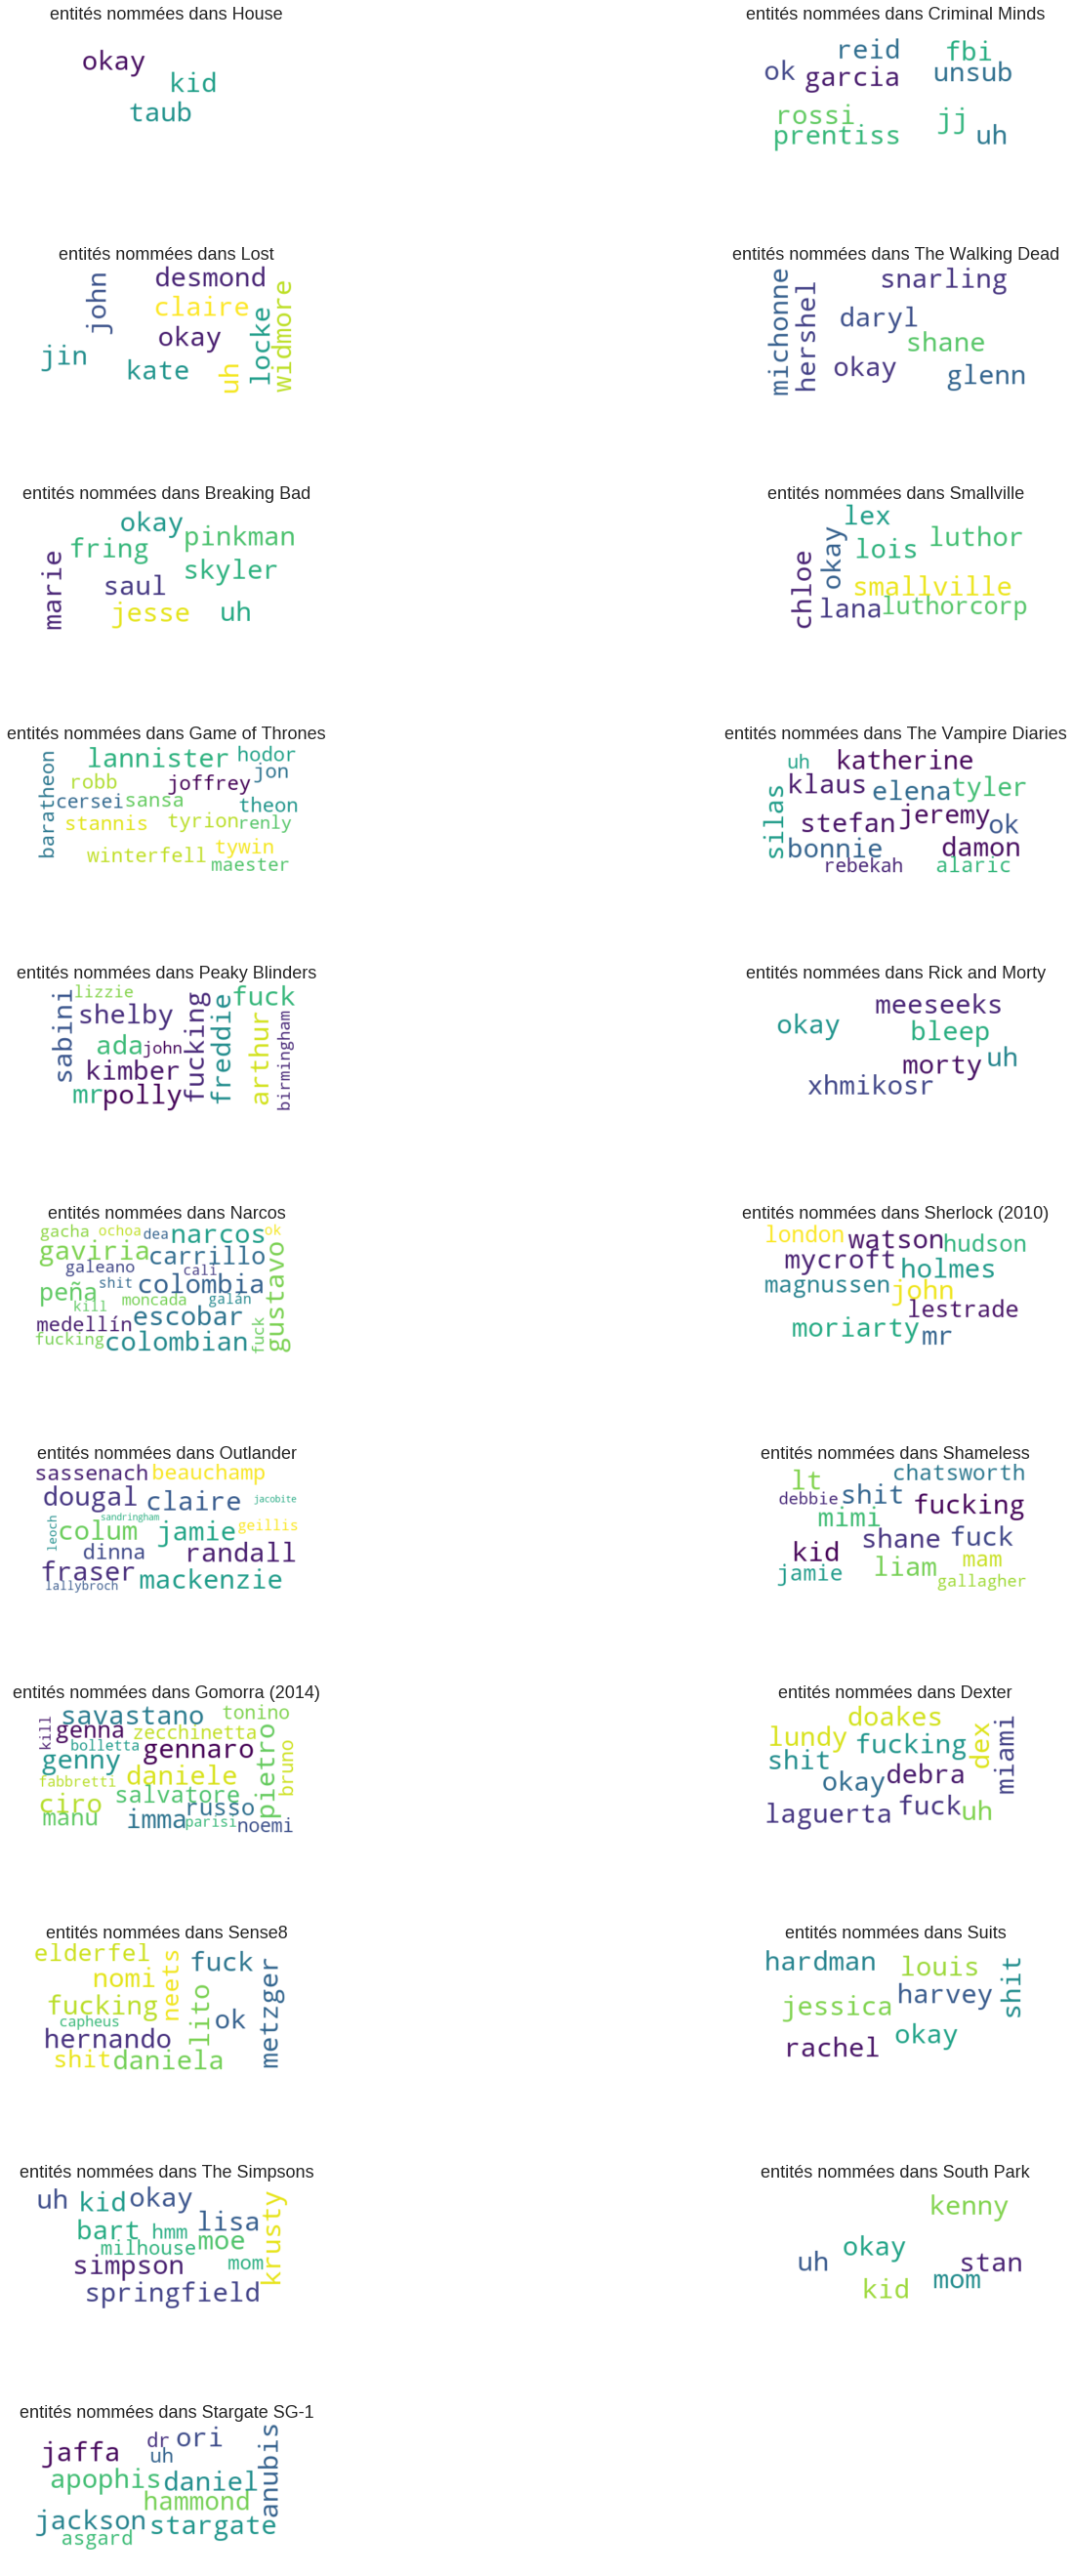

In [15]:
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

from nltk.corpus import words as nltk_words

def is_english(word):
    #thanks to stackoverflow - https://stackoverflow.com/a/38062250
    # creation of this dictionary would be done outside of 
    #     the function because you only need to do it once.
    dictionary = dict.fromkeys(nltk_words.words(), None)
    try:
        x = dictionary[word]
        return True
    except KeyError:
        return False


corpus = []

for serie in series:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.tokens") #fichiers normalisés
    text = ""
    for episode in listepisodes:
        with codecs.open(episode, "r", "utf-8") as file:
            text += " " + file.read()
    corpus.append(text)

vectorizer = TfidfVectorizer(lowercase = True, binary = False, analyzer = 'word', use_idf = True, stop_words = 'english')
#tf-idf vectorizer
X = vectorizer.fit_transform(corpus)
terms = vectorizer.get_feature_names()
words_n = 50
mots = []
for serie in range(len(corpus)):
    feature_index = X[serie, :].nonzero()[1]
    tfidf_scores = zip(feature_index, [X[serie, x] for x in feature_index])
    doc_terms = []
    for word, score in [(terms[i], score) for (i, score) in tfidf_scores]:
        doc_terms.append((word, score))
    important_terms = [(word, score) for word, score in sorted(doc_terms, key=lambda x: x[1], reverse=True)][:words_n]

    text = [word for word, tag in pos_tag([word for word, score in important_terms]) if (tag=='NNP' or not is_english(word))]
    mots.append(text)


plt.figure(figsize=(30,45))
index = 1
for i in range(len(mots)):
    nomserie = " ".join(series[i].split("_")[1:])
    wordcloud = WordCloud(background_color="white", max_font_size=40).generate(" ".join(mots[i]))
    plt.subplot(11, 2, index)
    plt.title("entités nommées dans "+nomserie, fontsize=18)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    index += 1
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.8, wspace=0.05)
plt.show()

#### Résultat:

Assez décevant globalement. Dans les simpsons, on ne retrouve ni marge, ni homer... pourtant présents plus haut dans les mots ayant le plus grand tf-idf. Dans smallville, il n'y a ni clark, ni kent (un peu dommage!). Certains mots du langage courant ou onomatopées se retrouvent là, comme par exemple "uh" "hey" ou "hmm".

Il faut utiliser une meilleure stratégie d'extraction.